In [1]:
import sys
sys.path.insert(0, '../')

import pandas as pd
from preprocess import Audio_Processor
import data_utils as du
from sklearn import metrics
import time

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

from classification_plots import plot_confusion_matrix, plot_learning_curve
import matplotlib.pyplot as plt
import os
from collections import Counter
import numpy as np

Using TensorFlow backend.


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="0"

SR = 16000
blocksize = int(SR/2)
overlap = int(SR/4)

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Setup

In [4]:
audio_dir = '../../ESC-50/audio/'

In [5]:
path_to_db='../../ESC-50/'
ps = Audio_Processor(path_to_db + 'audio/')

# Load Dataset
Here we load the csv that describes each file in the dataset. We add a high level category that is defined in the ESC-50 documentation. This we realize is anthetical to true training, it is a stopgap for when we use NLP to classify tags into these categories.

In [6]:
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50

In [7]:
h_classes = ['Human & Animal', 'Interacting Materials']
mapping = {'dog': 0,'rooster': 0,'pig': 0,'cow': 0,'frog': 0,'cat': 0,'hen': 0,
            'insects': 0,'sheep': 0,'crow': 0,'rain': 1,'sea_waves': 1,'crackling_fire': 1,
            'crickets': 0,'chirping_birds': 0,'water_drops': 1,'wind': 1,'pouring_water': 1,
            'toilet_flush': 1,'thunderstorm': 1,'crying_baby': 0,'sneezing': 0,'clapping': 0,
            'breathing': 0,'coughing': 0,'footsteps': 1,'laughing': 0,'brushing_teeth': 1,
            'snoring': 0,'drinking_sipping': 1,'door_wood_knock': 1,'mouse_click': 1,
            'keyboard_typing': 1,'door_wood_creaks': 1,'can_opening': 1,'washing_machine': 1,
            'vacuum_cleaner': 1,'clock_alarm': 1,'clock_tick': 1,'glass_breaking':1,'helicopter': 1,
            'chainsaw': 1,'siren': 1,'car_horn': 1,'engine': 1,'train': 1,'church_bells': 1,
            'airplane': 1,'fireworks': 1,'hand_saw': 1,
            }

In [8]:
dataset['h_target'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_target'] = mapping[row['category']]

In [9]:
dataset.head()

,filename,fold,target,category,esc10,src_file,take,h_target
0,1-100032-A-0.wav,1,0,dog,True,100032,A,0
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A,0
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A,1
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B,1
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A,1


In [10]:
df = ps.preprocess_fold(dataset,
                        kind='quantized',
                        blocksize=blocksize,
                        overlap=overlap,
                        n_mels=128,
                        power_melgram=2.0,
                        decibel_gram=True,
                        feature_bag=False,
                        folds=3
                       )

Preprocess file not found, building new one
Epoch 1/1
2/2 [==============================] - 0s 91ms/step - loss: 1.3261
Init 1/3 with method: k-means++
Inertia for init 1/3: 367060.839385
Init 2/3 with method: k-means++
Inertia for init 2/3: 366683.679510
Init 3/3 with method: k-means++
Inertia for init 3/3: 367009.537073
Minibatch iteration 1/2800: mean batch inertia: 3.100848, ewa inertia: 3.100848 
Minibatch iteration 2/2800: mean batch inertia: 3.063231, ewa inertia: 3.098075 
Minibatch iteration 3/2800: mean batch inertia: 3.043523, ewa inertia: 3.094053 
Minibatch iteration 4/2800: mean batch inertia: 3.054557, ewa inertia: 3.091141 
Minibatch iteration 5/2800: mean batch inertia: 3.033295, ewa inertia: 3.086876 
Minibatch iteration 6/2800: mean batch inertia: 3.045605, ewa inertia: 3.083833 
Minibatch iteration 7/2800: mean batch inertia: 3.038648, ewa inertia: 3.080502 
Minibatch iteration 8/2800: mean batch inertia: 3.058549, ewa inertia: 3.078883 
Minibatch iteration 9/2800:

Minibatch iteration 98/2800: mean batch inertia: 2.951355, ewa inertia: 2.972291 
Minibatch iteration 99/2800: mean batch inertia: 2.997672, ewa inertia: 2.974163 
Minibatch iteration 100/2800: mean batch inertia: 2.975562, ewa inertia: 2.974266 
Minibatch iteration 101/2800: mean batch inertia: 2.963701, ewa inertia: 2.973487 
Minibatch iteration 102/2800: mean batch inertia: 2.948542, ewa inertia: 2.971648 
Minibatch iteration 103/2800: mean batch inertia: 2.957286, ewa inertia: 2.970589 
Minibatch iteration 104/2800: mean batch inertia: 2.981890, ewa inertia: 2.971422 
Minibatch iteration 105/2800: mean batch inertia: 2.971987, ewa inertia: 2.971464 
Minibatch iteration 106/2800: mean batch inertia: 2.960520, ewa inertia: 2.970657 
Minibatch iteration 107/2800: mean batch inertia: 2.974953, ewa inertia: 2.970974 
Minibatch iteration 108/2800: mean batch inertia: 2.968944, ewa inertia: 2.970824 
Minibatch iteration 109/2800: mean batch inertia: 2.971189, ewa inertia: 2.970851 
Miniba

In [11]:
df.head()

label,0,1,2,3,4,5,6,7,8,9,...,2040,2041,2042,2043,2044,2045,2046,2047,target,fold
0,0.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14,2
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,36,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36,2
4,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,3.0,19,3


## Getting Preprocessed Data
We allow for previously preprocessed data to be retrieved for faster training turnaround. If the fold has been preprocessed, it is loaded but if not it is processed and saved.

In [12]:
X_train = df[df.fold > 1].drop(['fold', 'target'], axis=1)
X_test = df[df.fold == 1].drop(['fold', 'target'], axis=1)
y_train = df[df.fold > 1]['target']
y_test = df[df.fold == 1]['target']

In [13]:
X_train.shape

(1333, 2048)

In [14]:
y_train.shape

(1333,)

# Deep Net
Separate into classes

In [15]:
from sklearn.svm import SVC

clf = Pipeline([
#     ('scaler', MinMaxScaler()),
#     ('feat_sel', SelectKBest(k=80, score_func=chi2)),
#     ('feat_red', PCA(n_components=50)),
    ('classify', SVC(C=3, cache_size=200, class_weight=None, coef0=0.0,
                      decision_function_shape='ovr', degree=1, gamma='scale', kernel='poly',
                      max_iter=1000, probability=True, random_state=42, shrinking=True,
                      tol=0.001, verbose=False)
    )
])

clf.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('classify', SVC(C=3, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=1, gamma='scale', kernel='poly',
  max_iter=1000, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False))])

0.34182908545727136
Confusion matrix, without normalization
[[4 0 0 ... 0 0 0]
 [1 4 0 ... 0 0 0]
 [0 0 3 ... 0 0 1]
 ...
 [0 0 0 ... 2 0 1]
 [0 0 0 ... 0 7 0]
 [0 0 0 ... 0 0 6]]


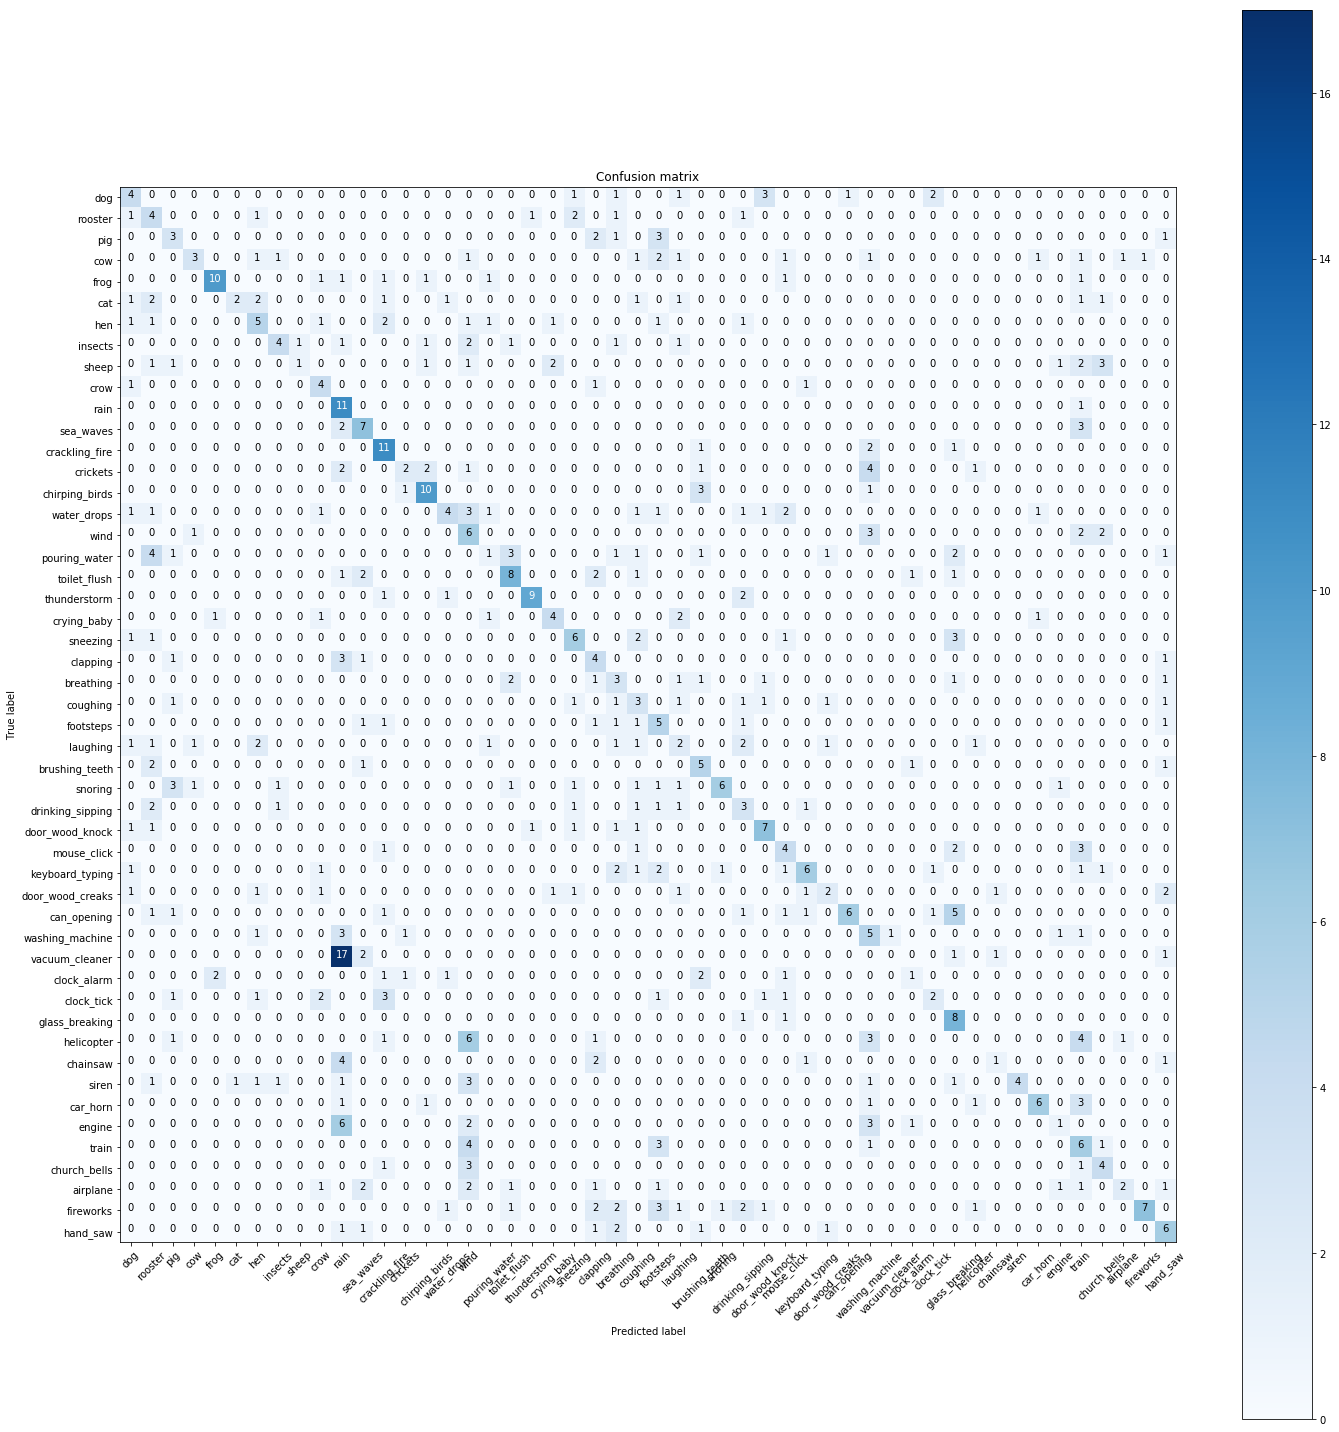

In [16]:
pred = clf.predict(X_test)
print(metrics.accuracy_score(y_test, pred))
cm = metrics.confusion_matrix(y_test, pred)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, classes)
plt.show()

In [17]:
y_test = y_test.reset_index(drop=True)

In [18]:
X_test = X_test.reset_index(drop=True)

In [19]:
%%time

predictions = []
full_targets = []
start_time = time.time()
pred_probs = []
time_per_file = []

for data_iloc in range(0,len(y_test)):
    s_time = time.time()
    x_file = X_test[X_test.index == data_iloc]
    
    y_file = y_test[data_iloc]
    
    pred = clf.predict(x_file)
    predictions.append(pred)
    
    full_targets.append(y_file)
    time_per_file.append(time.time() - s_time)
    print("\tFile Time: " + str(time.time() - s_time))

print("\tAverage File Time: " + str(np.average(time_per_file)))
print("\tProcessing Time: " + str(time.time() - start_time))

	File Time: 0.5986721515655518
	File Time: 0.4981520175933838
	File Time: 0.4585757255554199
	File Time: 0.4659156799316406
	File Time: 0.6973681449890137
	File Time: 0.46160888671875
	File Time: 0.4544370174407959
	File Time: 0.47117042541503906
	File Time: 0.44828271865844727
	File Time: 0.45694661140441895
	File Time: 0.4701874256134033
	File Time: 0.4717411994934082
	File Time: 0.458568811416626
	File Time: 0.624502420425415
	File Time: 0.44515180587768555
	File Time: 0.45551323890686035
	File Time: 0.46056056022644043
	File Time: 0.4717092514038086
	File Time: 0.4876134395599365
	File Time: 0.47252798080444336
	File Time: 0.46043944358825684
	File Time: 0.45928239822387695
	File Time: 0.6577801704406738
	File Time: 0.47455358505249023
	File Time: 0.45457029342651367
	File Time: 0.4774465560913086
	File Time: 0.47659897804260254
	File Time: 0.4785799980163574
	File Time: 0.4664890766143799
	File Time: 0.4559950828552246
	File Time: 0.6278307437896729
	File Time: 0.4765584468841553


	File Time: 0.45935988426208496
	File Time: 0.45313143730163574
	File Time: 0.4519314765930176
	File Time: 0.6179792881011963
	File Time: 0.45502448081970215
	File Time: 0.4447760581970215
	File Time: 0.4457368850708008
	File Time: 0.4512944221496582
	File Time: 0.4582352638244629
	File Time: 0.45968198776245117
	File Time: 0.4619009494781494
	File Time: 0.4567699432373047
	File Time: 0.6221990585327148
	File Time: 0.44962525367736816
	File Time: 0.445171594619751
	File Time: 0.4431891441345215
	File Time: 0.46463441848754883
	File Time: 0.4577467441558838
	File Time: 0.46718525886535645
	File Time: 0.45258212089538574
	File Time: 0.6535353660583496
	File Time: 0.462787389755249
	File Time: 0.4834778308868408
	File Time: 0.46315503120422363
	File Time: 0.5001053810119629
	File Time: 0.4609224796295166
	File Time: 0.4568302631378174
	File Time: 0.454129695892334
	File Time: 0.4708890914916992
	File Time: 0.6302523612976074
	File Time: 0.46467018127441406
	File Time: 0.4611952304840088
	

	File Time: 0.46918487548828125
	File Time: 0.48035478591918945
	File Time: 0.6677517890930176
	File Time: 0.4612257480621338
	File Time: 0.4834015369415283
	File Time: 0.4713578224182129
	File Time: 0.44788670539855957
	File Time: 0.44655656814575195
	File Time: 0.4293668270111084
	File Time: 0.4441797733306885
	File Time: 0.6136929988861084
	File Time: 0.453385591506958
	File Time: 0.44702792167663574
	File Time: 0.4645843505859375
	File Time: 0.4658513069152832
	File Time: 0.46265482902526855
	File Time: 0.46100831031799316
	File Time: 0.46360254287719727
	File Time: 0.4608747959136963
	File Time: 0.6179189682006836
	File Time: 0.44791316986083984
	File Time: 0.4508018493652344
	File Time: 0.4584949016571045
	File Time: 0.45642733573913574
	File Time: 0.45198726654052734
	File Time: 0.45049381256103516
	File Time: 0.4568674564361572
	File Time: 0.45704078674316406
	File Time: 0.6146759986877441
	File Time: 0.4659593105316162
	File Time: 0.46831750869750977
	File Time: 0.441276550292

0.34182908545727136
0.39250746534019776
Confusion matrix, without normalization
[[4 0 0 ... 0 0 0]
 [1 4 0 ... 0 0 0]
 [0 0 3 ... 0 0 1]
 ...
 [0 0 0 ... 2 0 1]
 [0 0 0 ... 0 7 0]
 [0 0 0 ... 0 0 6]]


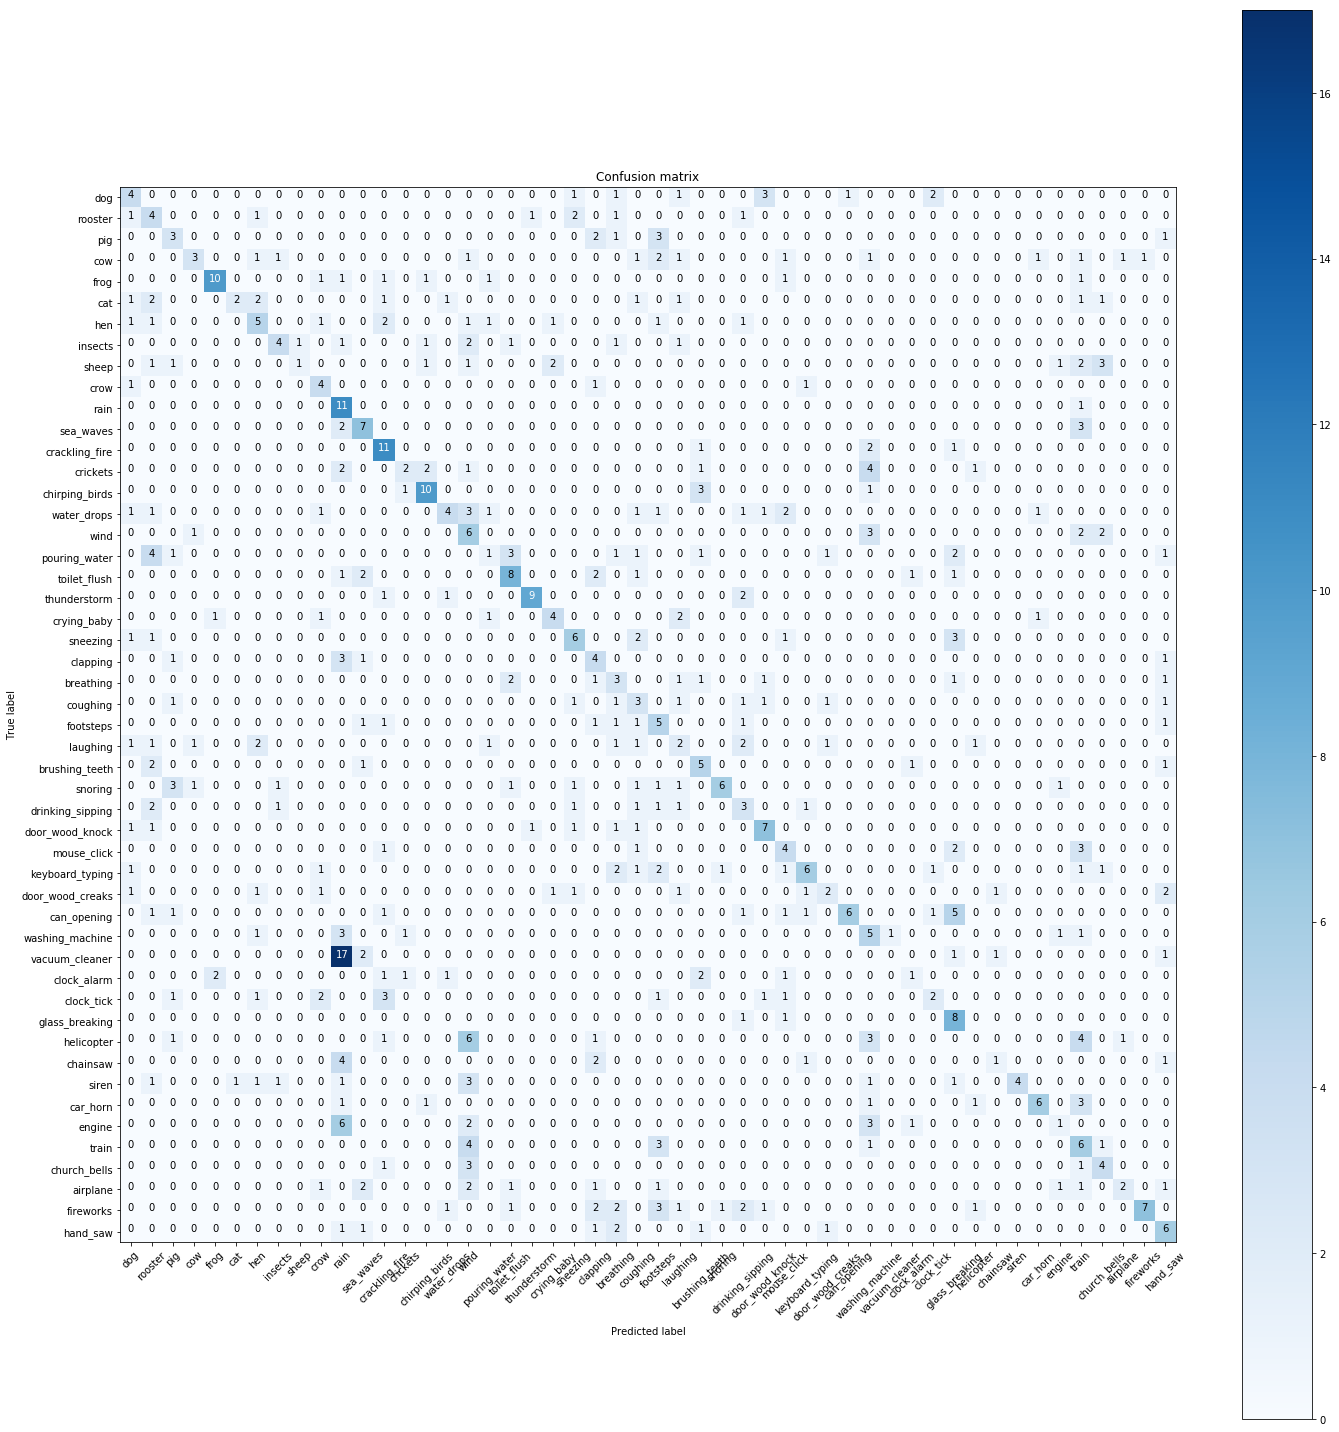

In [20]:
print(metrics.accuracy_score(full_targets, predictions))
print(metrics.precision_score(full_targets, predictions, average='macro'))
cm = metrics.confusion_matrix(full_targets, predictions)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, classes)
plt.show()

# Cross Validation

In [21]:
%%time
from sklearn.model_selection import cross_validate

clf = Pipeline([
#     ('scaler', MinMaxScaler()),
#     ('feat_sel', SelectKBest(k=80, score_func=chi2)),
#     ('feat_red', PCA(n_components=50)),
    ('classify', SVC(C=3, cache_size=200, class_weight=None, coef0=0.0,
                      decision_function_shape='ovr', degree=1, gamma='scale', kernel='poly',
                      max_iter=1000, probability=True, random_state=42, shrinking=True,
                      tol=0.001, verbose=False)
    )
])

scores = cross_validate(clf, X_train, y_train, cv=3, scoring=['accuracy', 'precision_macro', 'recall_macro'])

CPU times: user 1min 5s, sys: 52 ms, total: 1min 5s
Wall time: 1min 5s


In [22]:
clf.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('classify', SVC(C=3, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=1, gamma='scale', kernel='poly',
  max_iter=1000, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False))])

In [23]:
pd.DataFrame(scores)

,fit_time,score_time,test_accuracy,test_precision_macro,test_recall_macro,train_accuracy,train_precision_macro,train_recall_macro
0,14.468235,2.489977,0.283224,0.361482,0.273995,0.941648,0.956246,0.939614
1,14.805493,2.462751,0.291196,0.317085,0.284074,0.931461,0.943494,0.932226
2,14.965365,2.407591,0.308585,0.332408,0.306518,0.919069,0.940230,0.916799


In [24]:
def query_dataset(query_term):
    h_l = mapping[query_term]
    l_l = classes.index(query_term)

    predictions = []
    test = df[df.fold == 1]

    for data_iloc in range(0,len(X_test)):
        x_file = X_test[X_test.index == data_iloc]
    
        y_file = y_test[data_iloc]
        
        y_file = dataset.iloc[data_iloc].h_target
        yy_file = dataset.iloc[data_iloc].target

        predictions.append({
            'file': dataset.iloc[data_iloc].filename,
            'ds_id': data_iloc,
            'prob': np.average(clf.predict_proba(x_file)[:,l_l]),
            'prediction': clf.predict(x_file)
        })
    
    predictions = pd.DataFrame(predictions).sort_values(by=['prob'], ascending=False).reset_index(drop=True)
    
    return predictions

In [25]:
%%time
preds = query_dataset('dog')

CPU times: user 5min 16s, sys: 1.94 s, total: 5min 18s
Wall time: 5min 17s


In [ ]:
preds.head()

,ds_id,file,prediction,prob
0,532,2-125520-A-43.wav,[0],0.385558
1,351,1-79113-A-5.wav,[38],0.291200
2,434,2-106015-A-44.wav,[0],0.283619
3,478,2-114280-A-0.wav,[38],0.254765
4,342,1-75189-A-7.wav,[0],0.253367


In [ ]:
# Checking index
def check_accuracy(preds, query, count):
    misclass = []
    
    print(query)
    for data_iloc in range(0, count):
        row = preds.iloc[data_iloc]
        if dataset.iloc[row.ds_id].target != classes.index(query):
            misclass.append(classes[dataset.iloc[row.ds_id].target])
            
    print(misclass)
    print()
    return (count - len(misclass))/count

In [ ]:
# Checking index
check_accuracy(preds, 'dog', 10)

dog
['car_horn', 'cat', 'engine', 'insects', 'thunderstorm', 'crickets', 'glass_breaking', 'footsteps']



0.2

In [ ]:
accuracies = []
for cls in classes:
    %time preds = query_dataset(cls)
    %time acc = check_accuracy(preds, cls, 10)
    print(cls)
    print(acc)
    print()
    accuracies.append(acc)
    
np.average(accuracies)

CPU times: user 5min 16s, sys: 2.36 s, total: 5min 18s
Wall time: 5min 17s
dog
['car_horn', 'cat', 'engine', 'insects', 'thunderstorm', 'crickets', 'glass_breaking', 'footsteps']

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 5.66 ms
dog
0.2

CPU times: user 5min 17s, sys: 2.03 s, total: 5min 19s
Wall time: 5min 17s
rooster
['crow', 'helicopter', 'hen', 'pig', 'pig', 'cow', 'cat', 'fireworks', 'airplane', 'airplane']

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 6.13 ms
rooster
0.0

CPU times: user 5min 16s, sys: 2.18 s, total: 5min 18s
Wall time: 5min 16s
pig
['footsteps', 'crow', 'clock_tick', 'can_opening', 'crackling_fire', 'glass_breaking', 'helicopter', 'clock_alarm', 'glass_breaking', 'cow']

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 6.2 ms
pig
0.0

CPU times: user 5min 20s, sys: 2.08 s, total: 5min 22s
Wall time: 5min 20s
cow
['crying_baby', 'hand_saw', 'vacuum_cleaner', 'rain', 'dog', 'engine', 'pouring_water', 'pig', 'church_bells', 'wind']


CPU times: user 5min 12s, sys: 1.62 s, total: 5min 14s
Wall time: 5min 12s
drinking_sipping
['fireworks', 'clock_tick', 'washing_machine', 'glass_breaking', 'crickets', 'sheep', 'helicopter', 'crying_baby', 'laughing', 'can_opening']

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 5.88 ms
drinking_sipping
0.0

CPU times: user 5min 13s, sys: 1.53 s, total: 5min 15s
Wall time: 5min 13s
door_wood_knock
['dog', 'glass_breaking', 'fireworks', 'car_horn', 'glass_breaking', 'chirping_birds', 'chirping_birds', 'clock_tick', 'snoring', 'drinking_sipping']

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 5.93 ms
door_wood_knock
0.0

CPU times: user 5min 12s, sys: 1.82 s, total: 5min 13s
Wall time: 5min 12s
mouse_click
['door_wood_knock', 'door_wood_creaks', 'breathing', 'clock_tick', 'clock_alarm', 'siren', 'laughing', 'washing_machine', 'crackling_fire', 'chirping_birds']

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 5.86 ms
mouse_click
0.0

CPU times: user 5min 15s,